In [2]:
import numpy as np
import h5py

# array that has L elements which represents the number of units in each layer including the input layer

layers_dims = [12288, 128, 20, 7, 5, 1]
activations = ["sigmoid", "relu", "relu", "relu", "relu", "sigmoid"]
L = len(layers_dims) - 1

epsilon=1e-8

In [3]:

def load_data(train_path, test_path):
    train_dataset = h5py.File(train_path, "r")
    train_set_x_orig = np.array(
        train_dataset["train_set_x"][:]
    )  # your train set features
    train_set_y_orig = np.array(
        train_dataset["train_set_y"][:]
    )  # your train set labels

    test_dataset = h5py.File(test_path, "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:])  # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:])  # your test set labels

    classes = np.array(test_dataset["list_classes"][:])  # the list of classes

    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes



In [4]:
train_x_orig, train_y, test_x_orig, test_y, _ = load_data(
        "train_catvnoncat.h5", "test_catvnoncat.h5"
    )

In [5]:

def sigmoid(z):
    z=np.clip(z,-500,500)
    return 1 / (1 + np.exp(-z))


def relu(z):
    return np.maximum(0, z)


def der_sigmoid(x):
    return sigmoid(x)  (1 - sigmoid(x))


def der_relu(x):
    return np.where(x > 0, 1, 0)


In [6]:



def single_layer_initialization(units, n_x):
    Wi = np.random.randn(units, n_x) 
    bi = np.zeros((units, 1))
    return Wi, bi


def network_initialization(layers_dims: list):
    L = len(layers_dims) - 1
    parameters = {}
    grads = {}
    for l in range(L):
        (
            parameters["W" + str(l + 1)],
            parameters["b" + str(l + 1)],
        ) = single_layer_initialization(layers_dims[l + 1], layers_dims[l])
        grads["dW" + str(l + 1)] = np.zeros((layers_dims[l + 1], layers_dims[l]))
        grads["db" + str(l + 1)] = np.zeros((layers_dims[l + 1], 1))
    return parameters, grads


In [7]:


def single_layer_forward_prop(Ai, Wi, bi, activation):
    Zi = np.dot(Wi, Ai) + bi  # shape = (no_of_units,m)
    if activation == "relu":
        Ai = relu(Zi)
    elif activation == "sigmoid":
        Ai = sigmoid(Zi)
    return Ai, Zi


def network_forward_prop(X: np.ndarray, parameters: dict, activation: list):
    A1, Z1 = single_layer_forward_prop(
        X, parameters["W1"], parameters["b1"], activation[1]
    )
    A_layer = A1
    cache = {}
    cache["Z1"] = Z1
    cache["A1"] = A1
    cache["A0"] = X
    for l in range(2, L + 1):
        A_layer, Z_layer = single_layer_forward_prop(
            A_layer,
            parameters["W" + str(l)],
            parameters["b" + str(l)],
            activation[l],
        )
        cache["A" + str(l)] = A_layer
        cache["Z" + str(l)] = Z_layer
    AL = A_layer
    return AL, cache


In [8]:

def compute_cost(Y: np.ndarray, AL: np.ndarray, type: str):
    if type == "cross entropy":
        # cost = -1 * ((Y * np.log(AL)) + (1 - Y) * (np.log(1 - AL))).mean() old
        cost = -1 * ((Y * np.log(np.add(np.abs(AL),epsilon))) + (1 - Y) * (np.log(np.add(np.abs(1 - AL),epsilon)))).mean()
    return cost

def update_parameters(parameters, learning_rate, grads):
    for l in range(L):
        parameters["W" + str(l + 1)] = (
            parameters["W" + str(l + 1)] - learning_rate * grads["dW" + str(l + 1)]
        )
        parameters["b" + str(l + 1)] = (
            parameters["b" + str(l + 1)] - learning_rate * grads["db" + str(l + 1)]
        )
        return parameters



In [9]:


def back_prop(AL: np.ndarray,Y: np.ndarray,parameters: dict,grads: dict,cache: dict,activations: list):
    dZ = AL - Y
    m = Y.shape[1]
    for l in range(L, 0, -1):
        grads["dW" + str(l)] = np.dot(dZ, (cache["A" + str(l - 1)]).T) / m
        grads["db" + str(l)] = np.sum(dZ, axis=1, keepdims=True) / m
        if l == 1:
            break
        dZ = np.dot(parameters["W" + str(l)].T, dZ)
        if activations[l - 1] == "sigmoid":
            dZ = dZ * der_sigmoid(cache["Z" + str(l - 1)])
        else:
            dZ = dZ * der_relu(cache["Z" + str(l - 1)])
    return grads




def predict(X: np.ndarray, Y: np.ndarray, parameters: dict, activations: list):
    AL, _ = network_forward_prop(X, parameters, activations)
    AL = np.round(AL,0).astype(int)
    print("Accuracy: " + str(np.sum(AL == Y) / Y.shape[1]))
    return AL






In [10]:
def model(X, Y, activations, learning_rate, num_iterations):
    costs = []
    parameters, grads = network_initialization(layers_dims)
    for i in range(num_iterations):
        AL, cache = network_forward_prop(X, parameters, activations)
        cost = compute_cost(Y, AL, "cross entropy")
        grads = back_prop(AL, Y, parameters, grads, cache, activations)
        parameters = update_parameters(parameters, learning_rate, grads)
        if (i % 100 == 0) or (i == num_iterations):
            print(f"Iteration: {i} cost: {cost}")
        costs.append(cost)            
    return parameters, costs



In [11]:

def main():
    train_x_orig, train_y, test_x_orig, test_y, _ = load_data(
        "train_catvnoncat.h5", "test_catvnoncat.h5"
    )
    # Reshape the training and test examples
    train_x_flatten = train_x_orig.reshape(
        train_x_orig.shape[0], -1
    ).T  # The "-1" makes reshape flatten the remaining dimensions
    test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

    # Standardize data to have feature values between 0 and 1.
    train_x = train_x_flatten / 255.0
    test_x = test_x_flatten / 255.0

    parameters, costs = model(train_x, train_y, activations, 1e-2, 100)

    # parameters, _ = network_initialization(layers_dims)
    # print(parameters)
    # Al, __ = network_forward_prop(train_x, parameters, activations)
    # print(Al)

    Al = predict(test_x, test_y, parameters, activations)
    _ = predict(train_x, train_y, parameters, activations)
    return parameters, costs


In [12]:
params,costs=main()

Iteration: 0 cost: 6.345880441122348
Accuracy: 0.34
Accuracy: 0.6555023923444976


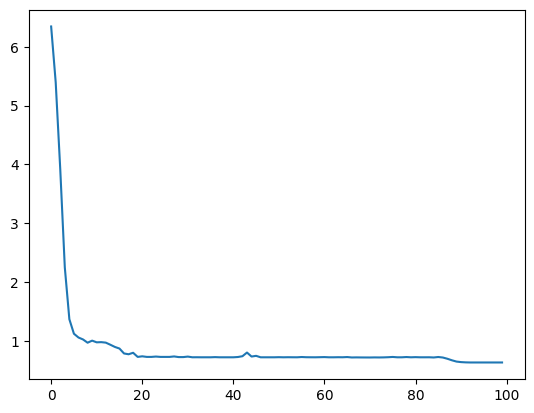

In [13]:
import matplotlib.pyplot as plt
Is,Cs=zip(*enumerate(costs))
plt.plot(Is,Cs)

In [14]:
print("hello")

hello
